GitHub page: https://github.com/ironavt/bank-customer-churn-modeling

# Customers churn

Clients have started leaving "Beta-Bank." Every month. Not many, but noticeably. Bank marketers have calculated that retaining existing customers is cheaper than attracting new ones.

It is necessary to predict whether a client will leave the bank in the near future or not. You are provided with historical data on client behaviour and contract terminations with the bank.

A model will be built to achieve the highest possible F1-score, with the metric needing to reach 0.59. Additionally, the AUC-ROC metric will be measured and compared to the F1-score.

Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Data preparation

In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

# random_state variable
rst = 48151623

# CopyWithWarning suppression
pd.options.mode.chained_assignment = None

# no limit for columns
pd.set_option('display.max_columns', None)

In [3]:
# open dataset
df = pd.read_csv('./datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()
df.describe().style.format("{:.2f}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,9091.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,15690940.57,650.53,38.92,5.00,76485.89,1.53,0.71,0.52,100090.24,0.20
std,2886.90,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,1.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,2500.75,15628528.25,584.00,32.00,2.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,5000.50,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,7500.25,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


In [5]:
# check features
for row in ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']:
    display(df[row].value_counts())
print(f"""
Missing values for Tenure: {df['Tenure'].isna().sum()}, rate of missing values is {df['Tenure'].isna().sum() / df.shape[0]}
Rate of positive values for Exited: {df['Exited'].sum() / df.shape[0]}
""")

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Gender
Male      5457
Female    4543
Name: count, dtype: int64

Tenure
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: count, dtype: int64

NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

HasCrCard
1    7055
0    2945
Name: count, dtype: int64

IsActiveMember
1    5151
0    4849
Name: count, dtype: int64

Exited
0    7963
1    2037
Name: count, dtype: int64


Missing values for Tenure: 909, rate of missing values is 0.0909
Rate of positive values for Exited: 0.2037



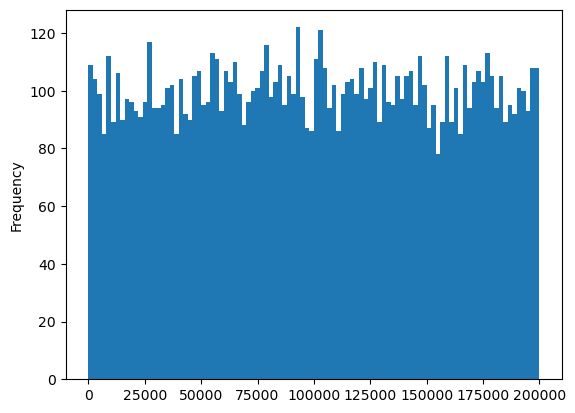

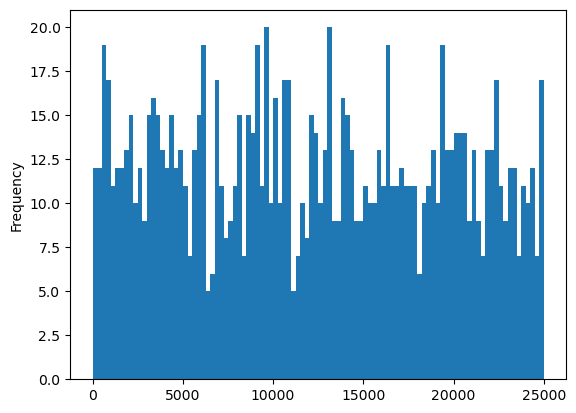

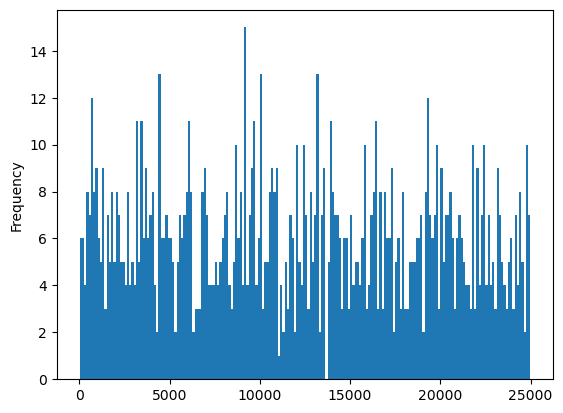

In [6]:
# Check EstimatedSlalry
df['EstimatedSalary'].plot(kind='hist', bins=100)
plt.show()
df.query('EstimatedSalary <= 25000')['EstimatedSalary'].plot(kind='hist', bins=100)
plt.show()
df.query('EstimatedSalary <= 25000')['EstimatedSalary'].plot(kind='hist', bins=200)
plt.show()

Column `EstimatedSalary` contains many low values. Check for the outliers.

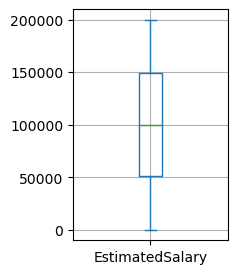

In [7]:
# check outliers
df['EstimatedSalary'].plot(kind='box', figsize=(2, 3), grid=True)
plt.show()

In the column with the salary rating, no outliers were found. Let's analyse the data distribution in the `Tenure` column to understand how best to fill in the missing values: with the mean or the median.

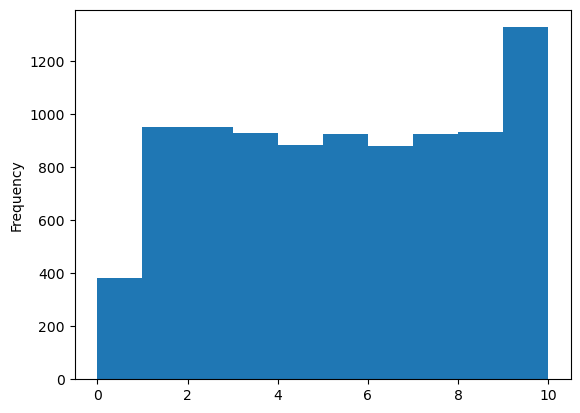

In [8]:
df['Tenure'].plot(kind='hist', bins=10)
plt.show()

### Preliminary Conclusion: Data

* The `RowNumber` column should be set as the index.
* The `Tenure` column contains both zeros and missing values; the missing values cannot be left as they are and need to be filled.
  * The data distribution does not have a pronounced mean but has a peak on the right side; in this case, the characteristic value for filling will be the **median**.
* The values in the `EstimatedSalary` column are evenly distributed across the entire range; there are both low and high values that are sufficiently widespread to not be considered outliers, and the distribution histograms do not have a peak.
  * Most likely, the values in the `EstimatedSalary` column are predicted by another model.
  * This is, of course, evident from the header, but it is still worth checking the estimate, as this data will influence the model training depending on whether they are included as a feature.
  * We will consider the *estimate* not related to real income but as a parameter determining the level of income.
  * Another reason for the uniform distribution of incomes may be that the available sample is stratified to contain an equal number of clients of different income levels.
    * This is hinted at by the third histogram: with an increased number of bins, it can be seen that the overall distribution actually consists of many overlapping normal distributions with local peaks in each group.

### Preliminary Conclusion: Features and Class Balance

* The `CustomerID` and `Surname` features will be excluded from the training as they do not represent any categorical or numerical expression of a person's financial activity.
* The categorical features `Geography` and `Gender` should be encoded using the OHE (One-Hot Encoding) principle.
  * The features `HasCrCard`, `IsActiveMember`, and `Exited`, although expressed as numbers, are categorical.
* The numerical features `CreditScore`, `Age`, `Tenure`, `Balance`, `NumOfProducts`, and `EstimatedSalary` require normalisation or the application of weight coefficients, as they differ significantly in their orders of magnitude.
* In the target feature column `Exited`, the positive class constitutes one-fifth of the total number of classes, which may represent a significant imbalance.

In [9]:
# RowNumber to index
df = df.set_index(keys='RowNumber')
df.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


Заполним пропуски медианным значением

In [10]:
# fill missing values
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


Since the task requires analysing two approaches to building the model, we will separate the samples for each case individually.

## Researching the task

### Features preparation

Drop columns `CustomerId` and `Surname`, split features `Geography` and `Gender` using OHE.

In [11]:
df2 = pd.get_dummies(df.drop(columns=['CustomerId', 'Surname']), drop_first=True)
df2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2.0,0.00,1,1,1,101348.88,1,False,False,False
2,608,41,1.0,83807.86,1,0,1,112542.58,0,False,True,False
3,502,42,8.0,159660.80,3,1,0,113931.57,1,False,False,False
4,699,39,1.0,0.00,2,0,0,93826.63,0,False,False,False
5,850,43,2.0,125510.82,1,1,1,79084.10,0,False,True,False


In [12]:
# extract features
X = df2.drop(columns=['Exited'])
# extract target feature
y = df2['Exited']
print(X.shape, y.shape)

(10000, 11) (10000,)


Let's create a small function to evaluate five metrics at once: the model, features, and target feature are given as input, and a dataframe row is returned, which can be appended in loops.

In [13]:
# metrics evaluation
def all_metrics(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    return pd.DataFrame([[accuracy_score(y_val, y_pred),
                          recall_score(y_val, y_pred),
                          precision_score(y_val, y_pred),
                          f1_score(y_val, y_pred),
                          roc_auc_score(y_val, y_proba[:, 1])]],
                        columns=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'])

### Model training without considering the class imbalance

Let's train the model without considering class imbalance and determine the metric values to assess the impact of this imbalance on the result. For evaluation, we will use **logistic regression** and **decision tree**. We will use `liblinear` as the solver for logistic regression, as it is better suited for relatively small datasets and less sensitive to class imbalance. The remaining parameters will be left unchanged.

Let's set aside one-fifth of the data to use as the test sample.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rst)
print(f"""
Train sample size: {X_train.shape}, {y_train.shape}
Test sample size: {X_test.shape}, {y_test.shape}
""")


Train sample size: (8000, 11), (8000,)
Test sample size: (2000, 11), (2000,)



In [15]:
# numerical features list
num_list = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [16]:
# create scaler and fit it
scaler = StandardScaler().fit(X_train[num_list])

In [17]:
# transform numerical features using fitted scaler
X_train[num_list] = scaler.transform(X_train[num_list])
X_test[num_list] = scaler.transform(X_test[num_list])
X_train.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
17,0.025110,1.794031,-1.447328,0.896437,-0.907235,1,0,-1.650202,True,False,True
6502,0.295713,-0.838564,1.451223,-1.230680,0.808575,1,0,1.000012,False,False,True
3062,-0.693028,-0.556500,-0.722690,0.185947,0.808575,1,1,1.343139,True,False,True


#### Descision tree

In [18]:
# colums for the final table
m = 'mean_test_'
r = 'rank_test_'
metrics = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

In [19]:
# iterate over the maximum depth of the decision tree and determine the metrics.
model_dt = DecisionTreeClassifier(random_state=rst)
param_dict = {'max_depth': list(range(2, 20))}

clf_dt = GridSearchCV(
    model_dt,
    param_dict,
    scoring=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'],
    verbose=1,
    refit='f1'
)

clf_dt.fit(X_train, y_train)
df_model_dt = pd.DataFrame(clf_dt.cv_results_)[['param_max_depth'] + [m + i for i in metrics] + [r + i for i in metrics]]
df_model_dt.sort_values(by='rank_test_f1').head()

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_max_depth,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,rank_test_accuracy,rank_test_recall,rank_test_precision,rank_test_f1,rank_test_roc_auc
4,6,0.857250,0.455753,0.751940,0.565983,0.828599,1,14,3,1,1
5,7,0.852375,0.458208,0.720152,0.559564,0.825132,3,13,5,2,3
6,8,0.848750,0.463702,0.697221,0.556690,0.811778,4,11,6,3,4
3,5,0.852625,0.452724,0.728674,0.555207,0.825369,2,15,4,4,2
8,10,0.834125,0.480193,0.624465,0.542456,0.764966,8,8,9,5,8


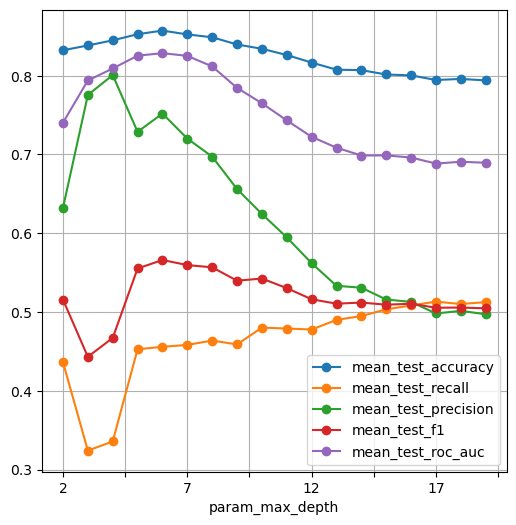

In [20]:
# plots
df_model_dt[['param_max_depth'] + [m + i for i in metrics]].plot(x='param_max_depth', grid=True, style='-o', figsize=(6, 6))
plt.show()

In [21]:
# let's test the best model on the test sample.
all_metrics(clf_dt.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.852,0.38191,0.752475,0.506667,0.83734


#### Logistic regression

In [23]:
# fit LR model and test the results
model_lr = LogisticRegression(random_state=rst).fit(X_train, y_train)
all_metrics(model_lr, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.8095,0.203518,0.558621,0.298343,0.765599


### Preliminary Conclusion

* Neither the decision tree nor the logistic regression achieved a satisfactory **F1-score**.
* The **F1-score** of the logistic regression is much lower than that of the decision tree: the sensitivity of logistic regression to class imbalance is much higher than that of the decision tree.
* The **ROC_AUC** metric is quite high in both cases, as it is insensitive to class imbalance.
* It is necessary to correct the class imbalance of the target feature.

## Class Balancing

### Class balancing: `class_weight` parameter

To address the class imbalance of the target feature, we will use the `class_weight` parameter when using the models.

#### Descision tree

As in the previous step, we will build the **decision tree** and **logistic regression** models, adding `class_weight = 'balanced'`.

In [24]:
# iterate over max depth and asses metrics
model_dt_balanced = DecisionTreeClassifier(random_state=rst, class_weight='balanced')
param_dict = {'max_depth': list(range(2, 20))}

clf_dt_balanced = GridSearchCV(
    model_dt_balanced,
    param_dict,
    scoring=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'],
    verbose=1,
    refit='f1'
)

clf_dt_balanced.fit(X_train, y_train)
df_model_dt_balanced = pd.DataFrame(clf_dt_balanced.cv_results_)[['param_max_depth'] + [m + i for i in metrics] + [r + i for i in metrics]]
df_model_dt_balanced.sort_values(by='rank_test_f1').head()

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_max_depth,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,rank_test_accuracy,rank_test_recall,rank_test_precision,rank_test_f1,rank_test_roc_auc
4,6,0.777500,0.735207,0.472485,0.575206,0.832102,12,3,13,1,1
5,7,0.784000,0.708975,0.482783,0.573982,0.826703,9,4,7,2,3
3,5,0.756000,0.773048,0.445743,0.564915,0.830707,15,1,15,3,2
6,8,0.780000,0.693731,0.475243,0.563809,0.801791,11,5,10,4,5
7,9,0.777125,0.674187,0.473412,0.554709,0.778244,13,8,12,5,7


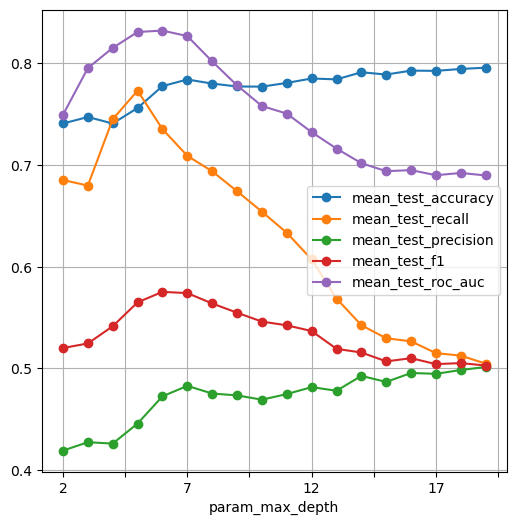

In [25]:
# plots
df_model_dt_balanced[['param_max_depth'] + [m + i for i in metrics]].plot(x='param_max_depth', grid=True, style='-o', figsize=(6, 6))
plt.show()

In [26]:
# test the best model on the test sample
all_metrics(clf_dt_balanced.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.7895,0.758794,0.481659,0.589268,0.844531


In [27]:
# for the reference: metrics with imbalanced classes
all_metrics(clf_dt.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.852,0.38191,0.752475,0.506667,0.83734


#### Logistic regression

In [28]:
# fit logistic regression and test the results
model_lr_balanced = LogisticRegression(random_state=rst, class_weight='balanced').fit(X_train, y_train)
all_metrics(model_lr_balanced, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.7015,0.688442,0.366801,0.478603,0.769569


In [29]:
# for the reference: metrics with imbalanced classes
all_metrics(model_lr, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.8095,0.203518,0.558621,0.298343,0.765599


#### Preliminary Conclusion
* The results are better than they were without class balancing, but the **F1-score** is still not high enough.
* **Recall** has increased significantly – this metric was strongly influenced by the small number of positive classes in the target feature; in the model with a balanced target feature, the weight of positive classes has increased.
* The **ROC-AUC** metric has practically not changed.
* We will use the **random forest** model and find the hyperparameters, and try to achieve the desired **F1-score**.

#### Random forest

Let's select the hyperparameters using `GridSearchCV`.

In [30]:
# iterate over n_estimators and max_depth
model_rf_balanced = RandomForestClassifier(random_state=rst, class_weight='balanced')
param_dict_rf = {'n_estimators': list(range(45, 55)),
                 'max_depth': list(range(7, 12))}

clf_rf_balanced = GridSearchCV(
    model_rf_balanced,
    param_dict_rf,
    scoring=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'], 
    verbose=1,
    refit='f1'
)

clf_rf_balanced.fit(X_train, y_train)
df_model_rf_balanced = pd.DataFrame(clf_rf_balanced.cv_results_)[['param_max_depth', 'param_n_estimators'] + [m + i for i in metrics] + [r + i for i in metrics]]
df_model_rf_balanced.sort_values(by='rank_test_f1').head()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,param_max_depth,param_n_estimators,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,rank_test_accuracy,rank_test_recall,rank_test_precision,rank_test_f1,rank_test_roc_auc
25,9,50,0.838875,0.649168,0.598769,0.622889,0.858707,21,21,21,1,2
36,10,51,0.846250,0.616836,0.627264,0.621928,0.856061,11,31,13,2,34
24,9,49,0.838125,0.647335,0.597044,0.621087,0.858676,23,25,23,3,3
27,9,52,0.838375,0.645508,0.598004,0.620792,0.858643,22,27,22,4,4
23,9,48,0.837750,0.647335,0.596216,0.620627,0.858541,25,24,25,5,7


In [31]:
# test the best model on the test sample
all_metrics(clf_rf_balanced.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.8275,0.663317,0.555789,0.604811,0.859863


#### Preliminary Conclusion
* Parameters have been found where the **F1-score** meets the project requirement, but this value is very close to 0.59.
* The **ROC-AUC** value of the best model is slightly higher than that of the decision tree.
* Let's see if we can increase the **F1-score** metric by increasing the number of positive classes.

### Class balancing: upsampling

The plan of action is as follows:
* Determine how much the negative class exceeds the positive class.
* Perform upsampling of the training sample for the positive class to achieve an equal number of classes.
  * The **random forest** and **decision tree** models will be used.
* Shuffle the training sample.
* Select hyperparameters for the random forest model using `GridSearchCV`.

In [32]:
# negative class exceeding
y[y == 0].shape[0] / y[y == 1].shape[0]

3.9091801669121256

In [33]:
# function for positive class upsampling
def upsample(X, y):
    X_0 = X[y == 0]
    X_1 = X[y == 1]
    y_0 = y[y == 0]
    y_1 = y[y == 1]
    repeat = X_0.shape[0] // X_1.shape[0] + 1
    X_upsampled = pd.concat([X_0] + [X_1] * repeat)
    y_upsampled = pd.concat([y_0] + [y_1] * repeat)
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=rst)
    return X_upsampled, y_upsampled

In [34]:
# apply upsampling function
X_train_up, y_train_up = upsample(X_train, y_train)
print(X_train_up.shape, y_train_up.shape)
print(y_train_up.value_counts())

(12917, 11) (12917,)
Exited
1    6556
0    6361
Name: count, dtype: int64


In [35]:
X_train_up.var()

CreditScore          1.034374
Age                  1.023824
Tenure               1.017570
Balance              0.971060
NumOfProducts        1.346440
HasCrCard            0.207625
IsActiveMember       0.247986
EstimatedSalary      1.005223
Geography_Germany    0.211577
Geography_Spain      0.178449
Gender_Male          0.249919
dtype: float64

#### Random forest

Let's select the hyperparameters using `GridSearchCV`.

In [36]:
# iterate over n_estimators and max_depth
model_rf_up = RandomForestClassifier(random_state=rst)
param_dict_up = {'n_estimators': list(range(45, 55)),
                 'max_depth': list(range(7, 12))}

clf_rf_up = GridSearchCV(
    model_rf_up,
    param_dict_up,
    scoring=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'],
    verbose=1,
    refit='f1',
    cv=5
)

clf_rf_up.fit(X_train_up, y_train_up)
df_model_rf_up = pd.DataFrame(clf_rf_up.cv_results_)[['param_max_depth', 'param_n_estimators'] + [m + i for i in metrics] + [r + i for i in metrics]]
df_model_rf_up.sort_values(by='rank_test_f1').head()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,param_max_depth,param_n_estimators,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,rank_test_accuracy,rank_test_recall,rank_test_precision,rank_test_f1,rank_test_roc_auc
47,11,52,0.880544,0.898109,0.870746,0.884179,0.952003,3,3,4,1,1
46,11,51,0.880544,0.898109,0.870739,0.884176,0.951867,2,4,5,2,2
49,11,54,0.880622,0.897346,0.871378,0.884149,0.951583,1,7,1,3,9
40,11,45,0.880467,0.898261,0.870471,0.884126,0.951523,4,2,6,4,10
42,11,47,0.880312,0.898262,0.870197,0.883988,0.951639,5,1,10,5,7


In [37]:
# test the best model on the test sample
all_metrics(clf_rf_up.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.8255,0.678392,0.549898,0.607424,0.857242


In [38]:
# for the reference: the best model w/o class upsampling but w/ balanced weights
all_metrics(clf_rf_balanced.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.8275,0.663317,0.555789,0.604811,0.859863


#### Descision tree

Let's select the hyperparameters using `GridSearchCV`.

In [39]:
# iterate over hp and determine metrics
model_dt_up = DecisionTreeClassifier(random_state=rst)
param_dict_up = {'max_depth': list(range(2, 12)),
                 'min_samples_split': [2, 3, 4],
                 'min_samples_leaf': [1, 2, 3],
                 'criterion': ['gini', 'entropy']}

clf_dt_up = GridSearchCV(
    model_dt_up,
    param_dict_up,
    scoring=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'],
    verbose=1,
    refit='f1'
)

clf_dt_up.fit(X_train_up, y_train_up)
df_model_dt_up = pd.DataFrame(clf_dt_up.cv_results_)[['param_max_depth',
                                                      'param_min_samples_split',
                                                      'param_min_samples_leaf',
                                                      'param_criterion'] + [m + i for i in metrics] + [r + i for i in metrics]]
df_model_dt_up.sort_values(by='rank_test_f1').head()

Fitting 5 folds for each of 180 candidates, totalling 900 fits


,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_criterion,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,rank_test_accuracy,rank_test_recall,rank_test_precision,rank_test_f1,rank_test_roc_auc
81,11,2,1,gini,0.838275,0.879500,0.816202,0.846594,0.905446,1,1,3,1,1
82,11,3,1,gini,0.837733,0.878585,0.815923,0.846027,0.905152,2,2,5,2,2
83,11,4,1,gini,0.835488,0.877212,0.813353,0.844017,0.902190,3,3,9,3,9
84,11,2,2,gini,0.832855,0.868211,0.814648,0.840488,0.902692,4,4,6,4,6
85,11,3,2,gini,0.832855,0.868211,0.814648,0.840488,0.902692,4,4,6,4,6


In [40]:
# test the best model on the test sample
all_metrics(clf_dt_up.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.755,0.655779,0.425081,0.51581,0.748552


In [41]:
# for the reference: the best model w/o class upsampling but w/ balanced weights
all_metrics(clf_dt_balanced.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.7895,0.758794,0.481659,0.589268,0.844531


#### Preliminary Conclusion
* The metric values on the test sample for the **random forest** using upsampling yielded almost the same results as using balanced weight coefficients.
  * The resulting model with the highest **F1-score** also has the highest **ROC-AUC** value.
  * The best model according to the **F1-score** metric has been saved in the `clf_rf_up` object in the `.best_estimator_` attribute.
* The **decision tree** model overfits and performs poorly on the test sample.

## Conclusion

* The best random forest model provided the following metric values:

In [42]:
all_metrics(clf_rf_up.best_estimator_, X_test, y_test)

,accuracy,recall,precision,f1,roc_auc
0,0.8255,0.678392,0.549898,0.607424,0.857242


* The following actions were taken during data preparation:
  * Missing values in the `Tenure` column were filled with the median value.
  * The columns `RowNumber`, `CustomerId`, and `Surname` were excluded from the training.
  * Numerical features were scaled using the standardisation method.
  * Class imbalance was addressed.
* Measures taken to address class imbalance increased not only the **F1-score** but also the **AUC-ROC** on validation.
  * The increase in **AUC-ROC** was not as dramatic because this metric is not as dependent on class imbalance.
  * Addressing class imbalance allowed for an increase in the model's **recall**.
* Using cross-validation increased the amount of data used for training.
* In the "Beta-Bank" case, the **recall** metric is more important than **precision**, as it is crucial to capture more clients who may potentially leave the bank.
  * This also depends on the measures taken to retain clients: if these measures do not affect the customers who are already satisfied but mistakenly fell into the "risk group," the value of **precision** is not as important as recall.